# Mini‑GAN on MNIST – Complete, Commented Example

Goal: show a minimal yet fully‑working Generative Adversarial Network that learns to create 28 × 28 handwritten‑digit images.
Framework: TensorFlow / Keras (tested with TF 2.19+).

In [ ]:
# -------------------------------------------
# 1) Imports & hyper‑parameters
# -------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, Reshape, Flatten, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

In [ ]:
LATENT_DIM = 100        # length of the random noise vector z
IMG_SHAPE  = (28, 28, 1)
BATCH      = 128
EPOCHS     = 2000
SHOW_EVERY = 1000       # iterations gap to visualise progress

Explanation

numpy gives fast vectorised maths; we need it for noise generation and reshaping.

matplotlib lets us preview generated samples inside the training loop.

tensorflow.keras is our high‑level API for defining and training neural nets.

LATENT_DIM is the size of the noise seed each fake image starts from.

IMG_SHAPE describes a single MNIST image (28 × 28, single channel).

IMG_SIZE flattens that spatial shape into a single integer; Dense layers require 1‑D input/output.

Remaining constants keep the experiment reproducible and quick to run in class.



# 2.Load & Normalise MNIST

In [ ]:
# -------------------------------------------
# 2) Load and prepare MNIST data
# -------------------------------------------
(X_train, _), _ = mnist.load_data()
X_train = X_train.astype("float32") / 127.5 - 1      # scale to [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)           # (60000, 28, 28, 1)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Explanation

mnist.load_data() gives 60k training images (and 10k test) shaped (28, 28). Labels aren’t needed for an unconditional GAN so we drop them.

GAN generators often end with a tanh activation (range [‑1, 1]). Scaling the real images to that same range speeds convergence and stabilises training.

reshape flattens each picture into a 1‑D vector because the simple network below uses fully‑connected layers, not convolutions.

# 3.Generator Network

In [ ]:
def build_generator():
    model = Sequential(name="Generator")

    model.add(Dense(7*7*128, use_bias=False, input_dim=LATENT_DIM))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))  # shape: (7, 7, 128)

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(LeakyReLU(0.2))        # output: (14, 14, 128)

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(LeakyReLU(0.2))        # output: (28, 28, 64)

    model.add(Conv2DTranspose(1, kernel_size=3, strides=1, padding='same', activation='tanh'))
    return model
G = build_generator()
G.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │       627,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       262,144 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           577 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,020,993 (3.89 MB)

 Trainable params: 1,020,993 (3.89 MB)

 Non-trainable params: 0 (0.00 B)

Explanation

Input layer takes a 100‑value random vector z. Dense means every input unit connects to every output feature.

LeakyReLU(0.2) allows a small gradient (slope = 0.2) when the unit is “off”, helping avoid dead neurons.

The second Dense expands 128 features into 784 pixel values, then tanh bounds them so they align with the real‑image range.

Reshape converts the flat 784 back to image dimensions, purely for visual convenience; numerically nothing changes.

# 4.Discriminator Network

In [ ]:
# -------------------------------------------
# 4) Build the Discriminator (CNN classifier)
# -------------------------------------------
def build_discriminator():
    model = Sequential(name="Discriminator")
    model.add(Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=IMG_SHAPE))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))        # probability real/fake
    return model
D = build_discriminator()
D.summary()

# compile D first
opt = Adam(0.0002, 0.5)
D.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

Explanation

Flatten converts either a real or generated image into a 784‑length vector.

Internal Dense + LeakyReLU learn hierarchical features that separate real from fake distributions.

Final unit uses a sigmoid; the scalar output is interpreted as the probability the input came from the real dataset.
 • Close to 1 → “looks real.”
 • Close to 0 → “looks synthetic.”

# 5.Compile & Stack Models

In [ ]:
G = build_generator()
D = build_discriminator()
opt_D = Adam(learning_rate=0.0002, beta_1=0.5)
opt_G = Adam(learning_rate=0.0002, beta_1=0.5)
D.compile(loss='binary_crossentropy', optimizer=opt_D, metrics=['accuracy'])

# GAN definition
D.trainable = False
z = Input(shape=(LATENT_DIM,))
fake_img = G(z)
validity = D(fake_img)
GAN = Model(z, validity, name="GAN")
GAN.compile(loss='binary_crossentropy', optimizer=opt_G)


Explanation

Adam is a popular adaptive optimiser; lowering beta_1 from default 0.9 to 0.5 often reduces oscillation in GAN games.

We compile D first so it can be trained stand‑alone.

Before building the stacked GAN, we set D.trainable = False; this ensures gradient updates flow only into G during generator training, leaving discriminator weights unchanged.

The Model that links input noise → G → D is what we fit when we want to improve the generator.

# 6.Main Training Loop

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1000/2000 | D_loss=0.637 D_acc=62.5% | G_loss=0.960


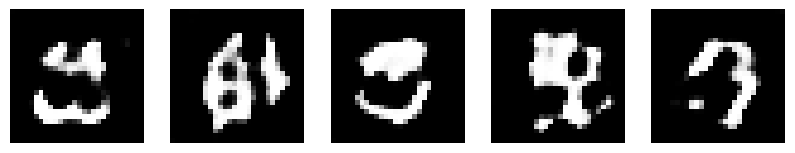

2000/2000 | D_loss=0.644 D_acc=63.0% | G_loss=0.922


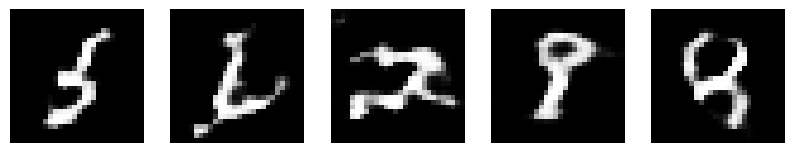

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

# -------------------------------------------
# 6) Training loop – GAN game
# -------------------------------------------

# Label arrays: 1 = real, 0 = fake
real_lbl = np.ones((BATCH, 1))
fake_lbl = np.zeros((BATCH, 1))

for step in range(1, EPOCHS + 1):

    # ----- 6‑A. Train Discriminator -----
    # 1) Sample a real image batch
    idx        = np.random.randint(0, X_train.shape[0], BATCH)
    real_imgs  = X_train[idx]

    # 2) Generate a matching fake batch
    noise      = np.random.normal(0, 1, (BATCH, LATENT_DIM))
    fake_imgs  = G.predict(noise, verbose=0)

    # 3) Enable D’s weights, then update with both batches
    D.trainable = True
    d_loss_real = D.train_on_batch(real_imgs, real_lbl)
    d_loss_fake = D.train_on_batch(fake_imgs, fake_lbl)
    d_loss      = 0.5 * np.add(d_loss_real, d_loss_fake)   # avg loss & acc

    # ----- 6‑B. Train Generator -----
    # 1) Freeze D, create new noise
    D.trainable = False
    noise = np.random.normal(0, 1, (BATCH, LATENT_DIM))

    # 2) We want D to label these fakes as REAL (label=1)
    g_loss = GAN.train_on_batch(noise, real_lbl)

    # ----- 6‑C. Progress output & visual check -----
    if step % SHOW_EVERY == 0:
        print(f"{step}/{EPOCHS} | D_loss={d_loss[0]:.3f} D_acc={d_loss[1]*100:.1f}% | G_loss={g_loss:.3f}")

        # generate 5 sample images for visual inspection
        sample_noise = np.random.normal(0, 1, (5, LATENT_DIM))
        gen_imgs = G.predict(sample_noise, verbose=0) * 0.5 + 0.5   # back to [0,1]
        fig, ax = plt.subplots(1, 5, figsize=(10, 2))
        for i in range(5):
            ax[i].imshow(gen_imgs[i].squeeze(), cmap='gray')
            ax[i].axis('off')
        plt.show()


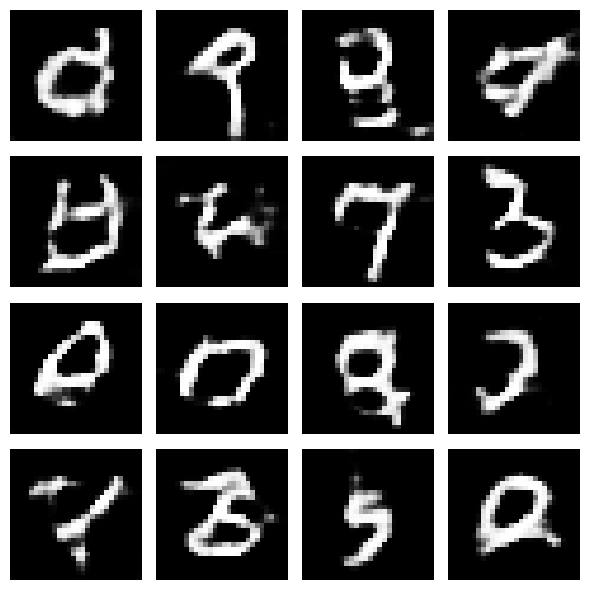

In [ ]:
# English comments inside code; Arabic explanation below
import matplotlib.pyplot as plt

# 1) Generate 16 new digits
noise = np.random.normal(0, 1, (16, LATENT_DIM))
gen_imgs = G.predict(noise, verbose=0) * 0.5 + 0.5   # back to [0,1]

# 2) Plot in a 4×4 grid
fig, axes = plt.subplots(4, 4, figsize=(6,6))
for i, ax in enumerate(axes.flat):
    ax.imshow(gen_imgs[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()
